In [1]:
import torch
import torch.nn as nn

from torchvision import datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

In [3]:
z_size = 100
chnl_size = 3
filter_g = 64
filter_d = 64
n_epochs = 200
lr = 0.0002

img_size = 64
batch_size = 128

transforms_train = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

train_dataset = datasets.OxfordIIITPet(root='./dataset',
                               download = True, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                         shuffle = True, num_workers=4)

# 가중치 초기화 함수
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:         # Conv weight init
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:  # BatchNorm weight init
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

  0%|          | 0/791918971 [00:00<?, ?it/s]

Extracting dataset/oxford-iiit-pet/images.tar.gz to dataset/oxford-iiit-pet


  0%|          | 0/19173078 [00:00<?, ?it/s]

Extracting dataset/oxford-iiit-pet/annotations.tar.gz to dataset/oxford-iiit-pet


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [4]:
# 생성자 정의

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            
            nn.ConvTranspose2d(z_size, filter_g*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(filter_g*8),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(filter_g*8, filter_g*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(filter_g*4),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(filter_g*4, filter_g*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(filter_g*2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(filter_g*2, filter_g*1, 4, 2, 1, bias=False),
            nn.BatchNorm2d(filter_g*1),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(filter_g*1, chnl_size, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, x):
        img = self.model(x)
        return img


# 판별자 정의

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            
            nn.Conv2d(chnl_size, filter_d, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(filter_d, filter_d*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(filter_d*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(filter_d*2, filter_d*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(filter_d*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(filter_d*4, filter_d*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(filter_d*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(filter_d*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        output = self.model(x)
        return output.view(-1,1).squeeze(1)

In [7]:
# 모델 학습 및 샘플링
generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

generator.apply(weights_init)
discriminator.apply(weights_init)

# 손실함수 정의
adversarial_loss = nn.BCELoss()
adversarial_loss.cuda()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5,0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5,0.999))

from torch.autograd import Variable

input = torch.cuda.FloatTensor(batch_size, 3, img_size, img_size)
noise = torch.cuda.FloatTensor(batch_size, z_size, 1, 1)
fixed_noise = torch.FloatTensor(batch_size, z_size, 1, 1).normal_(0, 1)
fixed_noise = Variable(fixed_noise)

label = torch.FloatTensor(batch_size)
real_label = 1
fake_label = 0


import time
start_time = time.time()

for epoch in range(200):
  for i, data in enumerate(dataloader):
    discriminator.zero_grad()
    real_cpu, _ = data
    real_imgs = real_cpu.cuda()
    batch_size = real_cpu.size(0)

    input.resize_as_(real_cpu).copy_(real_cpu)
    label.resize_(batch_size).fill_(real_label)
    inputv = Variable(input)
    labelv = Variable(label).cuda()
    d_loss_real = adversarial_loss(discriminator(inputv), labelv)

    noise.resize_(batch_size,z_size,1,1).normal_(0,1)
    noisev = Variable(noise)
    labelv = Variable(label.fill_(fake_label)).cuda()
    d_loss_fake = adversarial_loss(discriminator(generator(noisev)),labelv)
    
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    optimizer_D.step()

    generator.zero_grad()
    labelv = Variable(label.fill_(real_label)).cuda()
    g_loss = adversarial_loss(discriminator(generator(noisev)),labelv)
    g_loss.backward()
    optimizer_G.step()
  print(f"[Epoch {epoch}/{n_epochs}] [D loss : {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")


[Epoch 0/200] [D loss : 0.480089] [G loss: 16.584129] [Elapsed time: 21.36s]
[Epoch 1/200] [D loss : 0.371476] [G loss: 11.681609] [Elapsed time: 37.77s]
[Epoch 2/200] [D loss : 1.426421] [G loss: 6.481359] [Elapsed time: 55.03s]
[Epoch 3/200] [D loss : 0.749614] [G loss: 3.753497] [Elapsed time: 71.30s]
[Epoch 4/200] [D loss : 0.724487] [G loss: 3.992449] [Elapsed time: 87.67s]
[Epoch 5/200] [D loss : 0.588368] [G loss: 2.809555] [Elapsed time: 104.00s]
[Epoch 6/200] [D loss : 0.420766] [G loss: 5.930778] [Elapsed time: 121.84s]
[Epoch 7/200] [D loss : 0.941696] [G loss: 7.342481] [Elapsed time: 138.47s]
[Epoch 8/200] [D loss : 0.387014] [G loss: 5.243844] [Elapsed time: 154.84s]
[Epoch 9/200] [D loss : 0.337606] [G loss: 3.545519] [Elapsed time: 171.33s]
[Epoch 10/200] [D loss : 0.232276] [G loss: 5.039841] [Elapsed time: 187.82s]
[Epoch 11/200] [D loss : 0.674742] [G loss: 2.658897] [Elapsed time: 204.41s]
[Epoch 12/200] [D loss : 0.785831] [G loss: 5.895990] [Elapsed time: 220.67s]

In [9]:
from google.colab import drive
drive.mount('/content/drive')

torch.save({
    'netG' : generator.state_dict(),
    
    }, '/content/drive/MyDrive/Colab Notebooks/코드 실습/dcgan')

#state_dict = torch.load('/content/drive/MyDrive/Colab Notebooks/코드 실습/infoGAN_final!!_MNIST')

Mounted at /content/drive


In [16]:
outmap = generator(fixed_noise.cuda())

outmap_min, _ = torch.min(outmap, dim=1, keepdim=True)
outmap_max, _ = torch.max(outmap, dim=1, keepdim=True)
outmap = (outmap - outmap_min) / (outmap_max - outmap_min) # Broadcasting rules apply

outmap[0]

tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.9541, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.8846, 0.2494, 0.4527,  ..., 0.1214, 0.1762, 0.3484],
         [0.6046, 0.2491, 0.3308,  ..., 0.6047, 0.3591, 0.4083],
         [0.4705, 0.3929, 0.0000,  ..., 0.4693, 0.3479, 0.3689],
         ...,
         [0.6409, 0.0000, 0.0000,  ..., 0.4211, 0.7176, 0.3331],
         [0.5446, 0.0000, 0.0000,  ..., 0.4111, 0.5757, 0.4162],
         [1.0000, 0.0000, 0.0886,  ..., 0.4664, 0.3844, 0.4179]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0330,  ..., 0.0000, 0.0000, 0.

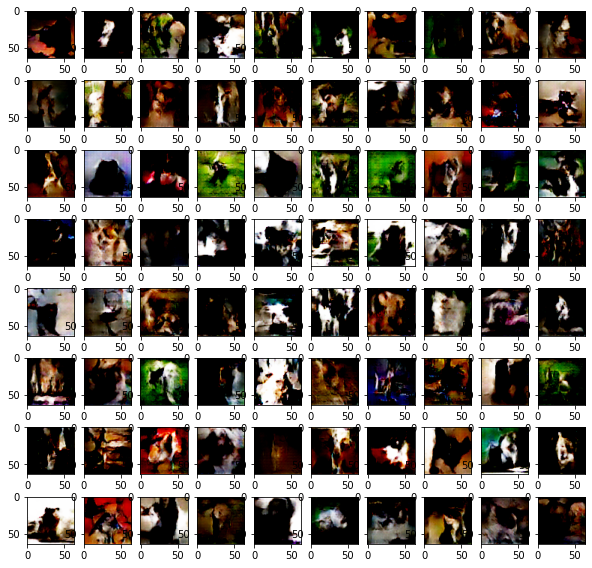

In [18]:
outmap = generator(fixed_noise.cuda())
rows,cols = 8,10
figure = plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
  figure.add_subplot(rows,cols,i)
  plt.imshow(outmap[i-1].cpu().detach().numpy().transpose((1,2,0)))
plt.show()